# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import time
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from nltk import pos_tag

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data['text'] = data['text'].str.lower()
data.head()

,Unnamed: 0,text,toxic
0,0,explanation\nwhy the edits made under my usern...,0
1,1,d'aww! he matches this background colour i'm s...,0
2,2,"hey man, i'm really not trying to edit war. it...",0
3,3,"""\nmore\ni can't make any real suggestions on ...",0
4,4,"you, sir, are my hero. any chance you remember...",0


In [6]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
data[data['text'].map(len) <= 10]

,Unnamed: 0,text,toxic
15432,15449,"howdy!""",0
52336,52393,"14:53,",0
109794,109891,{{unbloc,0
118650,118750,fuck you,1
119018,119123,"""""""",1
120868,120973,you suck,1
136820,136958,~ j.lo,0
137400,137547,"== """"""",0


In [8]:
data = data[data['text'].map(len) > 10]

In [9]:
data[data['text'].map(len) <= 10]

,Unnamed: 0,text,toxic


In [10]:
data = data.drop(columns=["Unnamed: 0"])

In [11]:
def clean_english_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # --- привести к нижнему регистру перед заменами ---
    text = text.lower()

    # --- словарь подмен сокращений ---
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am",
        "u": "you",
        "r": "are",
        "ya": "you",
        "thx": "thanks",
        "pls": "please",
        "plz": "please",
        "ok": "okay",
    }

    # --- замена сокращений ---
    for short, full in contractions.items():
        text = re.sub(rf"\b{re.escape(short)}\b", full, text)

    # --- оставить только латиницу и пробелы ---
    text = re.sub(r"[^a-z\s]", " ", text)

    # --- убрать лишние пробелы ---
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [12]:
data['text'] = data['text'].apply(clean_english_text)
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i am s...,0
2,hey man i am really not trying to edit war it ...,0
3,more i cannot make any real suggestions on imp...,0
4,you sir are my hero any chance you remember wh...,0


In [13]:
print(data['toxic'].value_counts(normalize=True) * 100)

0    89.84016
1    10.15984
Name: toxic, dtype: float64


In [14]:
data['number_of_words'] = data['text'].apply(len)
data.head()

,text,toxic,number_of_words
0,explanation why the edits made under my userna...,0,249
1,d aww he matches this background colour i am s...,0,89
2,hey man i am really not trying to edit war it ...,0,231
3,more i cannot make any real suggestions on imp...,0,603
4,you sir are my hero any chance you remember wh...,0,64


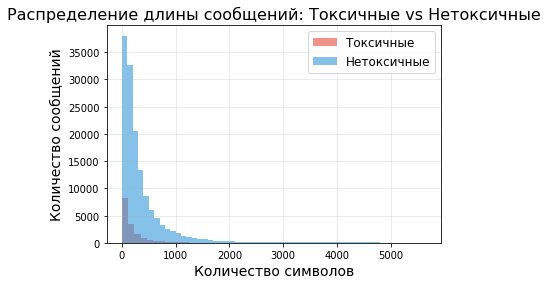

In [15]:
toxic = data[data['toxic'] == 1]
nontoxic = data[data['toxic'] != 1]

plt.hist(toxic['number_of_words'], bins=50, alpha=0.6, label='Токсичные', color='#e74c3c')
plt.hist(nontoxic['number_of_words'], bins=50, alpha=0.6, label='Нетоксичные', color='#3498db')

plt.xlabel('Количество символов', fontsize=14)
plt.ylabel('Количество сообщений', fontsize=14)
plt.title('Распределение длины сообщений: Токсичные vs Нетоксичные', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

<b>Вывод:</b>

- Первичный анализ предоставленных данных показал что столбцы и строки в правильном формате они не требуют изменения.
- Коментарии были переведены в нижний регистр.
- Решено удалить очень короткие комментарии, которые не несут никакой информации.
- С помощью функции была проведена восстановление укороченных слов, также был удален лишний столбец с индексом (Unnamed).
- Установлено что целевой признак несбалансирован (9 к 1), при разделении данных на тренировочную и тестовую выборку стоит применить стратификацию
- Длина слов не коррелирует с целевым признаком, то есть нет взаимосвязи между длиной и токсичностью сообщения. 

## Обучение

In [16]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words("english"))

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def tokenize_text(text: str):
    if not isinstance(text, str):
        return []
    text = re.sub(r"[^a-z\s]", " ", text.lower())
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 2 and t not in english_stopwords]
    return tokens

def lemmatize_text(text: str):
    tokens = tokenize_text(text)
    pos_tags = pos_tag(tokens)  
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    return lemmas

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [17]:
data['lem_text'] = data['text'].progress_apply(lemmatize_text)
display(data.head())

  0%|          | 0/159284 [00:00<?, ?it/s]

,text,toxic,number_of_words,lem_text
0,explanation why the edits made under my userna...,0,249,"[explanation, edits, make, username, hardcore,..."
1,d aww he matches this background colour i am s...,0,89,"[aww, match, background, colour, seemingly, st..."
2,hey man i am really not trying to edit war it ...,0,231,"[hey, man, really, try, edit, war, guy, consta..."
3,more i cannot make any real suggestions on imp...,0,603,"[make, real, suggestion, improvement, wonder, ..."
4,you sir are my hero any chance you remember wh...,0,64,"[sir, hero, chance, remember, page]"


In [18]:
target = data['toxic']
features = data['lem_text']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target) 

features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.50, random_state=12345, stratify=target_test)

In [19]:
features_train = [' '.join(doc) if isinstance(doc, list) else doc for doc in features_train]
features_valid = [' '.join(doc) if isinstance(doc, list) else doc for doc in features_valid]
features_test = [' '.join(doc) if isinstance(doc, list) else doc for doc in features_test]

stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

train_tf_idf = count_tf_idf.fit_transform(features_train)
valid_tf_idf = count_tf_idf.transform(features_valid)
test_tf_idf = count_tf_idf.transform(features_test)

In [20]:
f1 = make_scorer(f1_score)

In [21]:
print("\n--- Decision Tree ---")
params_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'criterion': ['gini']
}

dt = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

start = time.time()
search_dt = RandomizedSearchCV(
    dt,
    param_distributions=params_dt,
    scoring='f1',
    n_iter=5,
    cv=3,
    random_state=12345,
    n_jobs=-1,
    verbose=1
)
search_dt.fit(train_tf_idf, target_train)
print("Best params:", search_dt.best_params_)
print("Best F1 (valid):", f1_score(target_valid, search_dt.best_estimator_.predict(valid_tf_idf)))
print("Train time:", round(time.time() - start, 2), "sec")


--- Decision Tree ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 15, 'criterion': 'gini'}
Best F1 (valid): 0.5937558422134979
Train time: 129.75 sec


In [22]:
print("\n--- Logistic Regression ---")
params_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

lr = LogisticRegression(
    class_weight='balanced',
    random_state=12345,
    max_iter=2000
)

start = time.time()
search_lr = RandomizedSearchCV(
    lr,
    param_distributions=params_lr,
    scoring='f1',
    n_iter=3,
    cv=3,
    random_state=12345,
    n_jobs=-1,
    verbose=1
)
search_lr.fit(train_tf_idf, target_train)
print("Best params:", search_lr.best_params_)
print("Best F1 (valid):", f1_score(target_valid, search_lr.best_estimator_.predict(valid_tf_idf)))
print("Train time:", round(time.time() - start, 2), "sec")


--- Logistic Regression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'solver': 'liblinear', 'C': 10}
Best F1 (valid): 0.759208435649285
Train time: 131.02 sec


In [23]:
print("\n--- LightGBM ---")
params_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63],
    'reg_lambda': [0, 1, 5]
}

lgb = LGBMClassifier(
    class_weight='balanced',
    random_state=12345,
    n_jobs=-1
)

start = time.time()
search_lgb = RandomizedSearchCV(
    lgb,
    param_distributions=params_lgb,
    scoring='f1',    
    n_iter=5,        
    cv=2,             
    random_state=12345,
    verbose=1,
    n_jobs=-1
)
search_lgb.fit(train_tf_idf, target_train)
print("Best params:", search_lgb.best_params_)
print("Best F1 (valid):", f1_score(target_valid, search_lgb.best_estimator_.predict(valid_tf_idf)))
print("Train time:", round(time.time() - start, 2), "sec")



--- LightGBM ---
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best params: {'reg_lambda': 0, 'num_leaves': 31, 'n_estimators': 200, 'learning_rate': 0.1}
Best F1 (valid): 0.7387738078687613
Train time: 1768.19 sec


<b>Проверка лучшей модели на тестовой выборке</b>

In [24]:
best_lr = search_lr.best_estimator_

test_pred = best_lr.predict(test_tf_idf)

f1_test = f1_score(target_test, test_pred)
print("\n Проверка на тестовых данных F1:", round(f1_test, 4))


 Проверка на тестовых данных F1: 0.7517


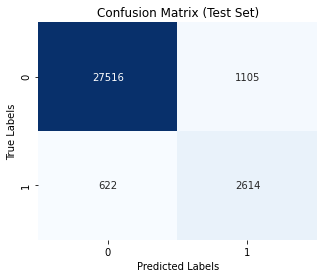

Classification Report:

              precision    recall  f1-score   support

           0     0.9779    0.9614    0.9696     28621
           1     0.7029    0.8078    0.7517      3236

    accuracy                         0.9458     31857
   macro avg     0.8404    0.8846    0.8606     31857
weighted avg     0.9500    0.9458    0.9474     31857



In [25]:
final_model = search_lr.best_estimator_

pred_test = final_model.predict(test_tf_idf)

cm = confusion_matrix(target_test, pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

report = classification_report(target_test, pred_test, digits=4)
print("Classification Report:\n")
print(report)

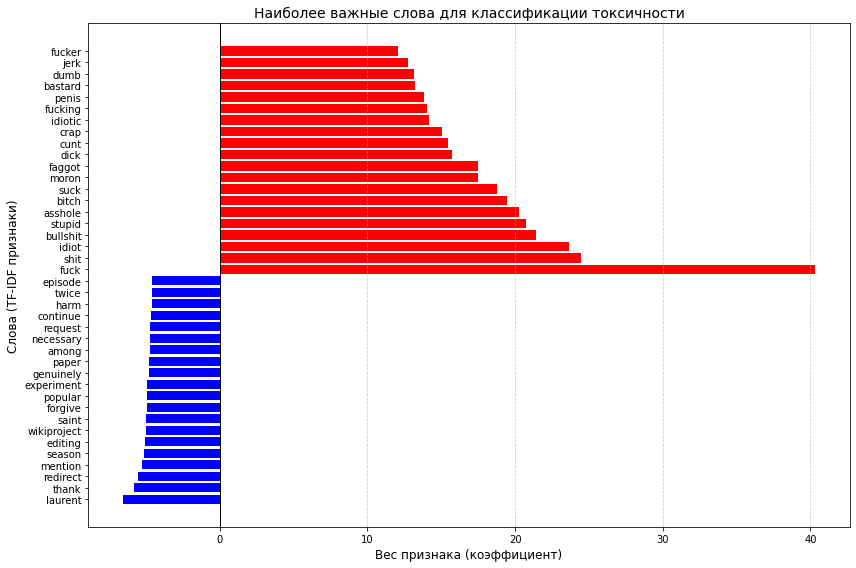

In [26]:
feature_names = count_tf_idf.get_feature_names()
coefficients = final_model.coef_[0]

importance = pd.DataFrame({
    'feature': feature_names,
    'coef': coefficients
})

top_positive = importance.sort_values(by='coef', ascending=False).head(20)
top_negative = importance.sort_values(by='coef', ascending=True).head(20)

top_words = pd.concat([top_negative, top_positive])

plt.figure(figsize=(12, 8))
colors = ['red' if c > 0 else 'blue' for c in top_words['coef']]

plt.barh(top_words['feature'], top_words['coef'], color=colors)
plt.axvline(0, color='black', linewidth=1)
plt.title("Наиболее важные слова для классификации токсичности", fontsize=14)
plt.xlabel("Вес признака (коэффициент)", fontsize=12)
plt.ylabel("Слова (TF-IDF признаки)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Выводы

- Был проведен первичный анализ предоставленных данных, проведено очистка признаков от дубликатов и коротких сообщений
- Установлено что целевой признак несбалансирован, т.е токсичные сообщение состоявляют 10%
- Из трех моделей лучшей себя показала LogisticRegression, у нее самый высокий показатель F1 - 0.76 (2 минуты), другие модели либо обучаются слишком долго (LGBMClassifier) либо дают предсказание хуже (DecisionTreeClassifier).

- True Negatives (TN) = 27 516 — модель правильно классифицировала нетоксичные сообщения.

- False Positives (FP) = 1 105 — модель ошибочно пометила нетоксичные как токсичные.

- False Negatives (FN) = 622 — токсичные сообщения, которые модель не распознала.

- True Positives (TP) = 2 614 — правильно распознанные токсичные комментарии.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны